## CNN. Детектирование

In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
dst_path1 = '/content/drive/MyDrive/annotations.zip'
dst_path2 = '/content/drive/MyDrive/images.zip'

In [5]:
from zipfile import ZipFile
zipfile1 = ZipFile(dst_path1)
zipfile1.extractall('/content/drive/MyDrive/annotations')

zipfile2 = ZipFile(dst_path2)
zipfile2.extractall('/content/drive/MyDrive/images')

In [6]:
images_path = Path('/content/drive/MyDrive/images')
anno_path = Path('/content/drive/MyDrive/annotations')

In [7]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [8]:
df_train = generate_train_df(anno_path)

In [9]:
print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/images/Cats_Test0.png,233,350,cat,83,29,197,142
1,/content/drive/MyDrive/images/Cats_Test1.png,500,500,dog,128,22,240,222
2,/content/drive/MyDrive/images/Cats_Test10.png,500,375,dog,157,56,264,116
3,/content/drive/MyDrive/images/Cats_Test100.png,500,375,cat,142,145,206,209
4,/content/drive/MyDrive/images/Cats_Test1000.png,335,500,cat,36,14,289,312


In [10]:
class_dict = {'dog': 0, 'cat': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [11]:
print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/images/Cats_Test0.png,233,350,1,83,29,197,142
1,/content/drive/MyDrive/images/Cats_Test1.png,500,500,0,128,22,240,222
2,/content/drive/MyDrive/images/Cats_Test10.png,500,375,0,157,56,264,116
3,/content/drive/MyDrive/images/Cats_Test100.png,500,375,1,142,145,206,209
4,/content/drive/MyDrive/images/Cats_Test1000.png,335,500,1,36,14,289,312


### Изменение размеров изображений и обрамляющих прямоугольников

In [12]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [13]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

In [14]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [15]:
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [16]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/drive/MyDrive/images/Cats_Test0.png,233,350,1,83,29,197,142,/content/drive/MyDrive/images_resized/Cats_Tes...,"[24.0, 158.0, 121.0, 378.0]"
1,/content/drive/MyDrive/images/Cats_Test1.png,500,500,0,128,22,240,222,/content/drive/MyDrive/images_resized/Cats_Tes...,"[13.0, 114.0, 132.0, 214.0]"
2,/content/drive/MyDrive/images/Cats_Test10.png,500,375,0,157,56,264,116,/content/drive/MyDrive/images_resized/Cats_Tes...,"[44.0, 140.0, 92.0, 235.0]"
3,/content/drive/MyDrive/images/Cats_Test100.png,500,375,1,142,145,206,209,/content/drive/MyDrive/images_resized/Cats_Tes...,"[116.0, 127.0, 167.0, 184.0]"
4,/content/drive/MyDrive/images/Cats_Test1000.png,335,500,1,36,14,289,312,/content/drive/MyDrive/images_resized/Cats_Tes...,"[8.0, 47.0, 186.0, 385.0]"


### Пример получившегося сэмпла

In [17]:
im = cv2.imread(str(df_train.values[19][0]))
bb = create_bb_array(df_train.values[19])
print(im.shape)

(500, 375, 3)


In [18]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 61., 195., 176., 373.], dtype=float32)

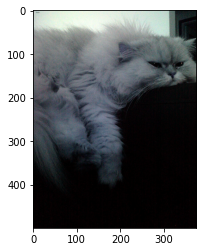

In [19]:
plt.imshow(im)

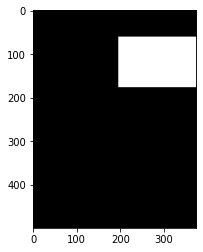

In [20]:
plt.imshow(Y, cmap='gray')

### Аугментация данных

In [21]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [22]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [23]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

### Пример изображения 

/content/drive/MyDrive/images_resized/Cats_Test1007.png


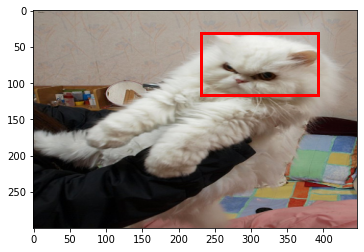

In [24]:
number = 11
im = cv2.imread(str(df_train.values[number][8]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[number][9])

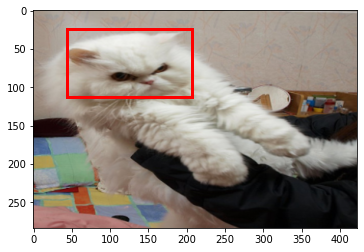

In [25]:
im, bb = transformsXY(str(df_train.values[number][8]),df_train.values[number][9],True )
show_corner_bb(im, bb)

### Датасет

In [26]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [28]:
class CatDogsDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [29]:
train_ds = CatDogsDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = CatDogsDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [30]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Определение модели

In [31]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

### Обучение

In [32]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
epochs = 15

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [33]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
#         print(y_bb.shape)
#         print(y_class.shape)
        out_class, out_bb = model(x)
#         print(out_bb.shape)
#         print(out_class.shape)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 1.230 val_loss 0.907 val_acc 0.653
train_loss 0.954 val_loss 1.130 val_acc 0.626
train_loss 0.873 val_loss 0.863 val_acc 0.657
train_loss 0.854 val_loss 0.838 val_acc 0.637
train_loss 0.859 val_loss 2.817 val_acc 0.539
train_loss 0.846 val_loss 1.486 val_acc 0.659
train_loss 0.832 val_loss 0.829 val_acc 0.645
train_loss 0.814 val_loss 0.831 val_acc 0.659
train_loss 0.809 val_loss 0.855 val_acc 0.659
train_loss 0.799 val_loss 0.808 val_acc 0.652
train_loss 0.796 val_loss 0.798 val_acc 0.659
train_loss 0.789 val_loss 0.794 val_acc 0.665
train_loss 0.780 val_loss 0.801 val_acc 0.654
train_loss 0.780 val_loss 0.795 val_acc 0.659
train_loss 0.778 val_loss 0.795 val_acc 0.660


In [35]:
for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = 0.001

In [36]:
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
#         print(out_bb.shape)
#         print(out_bb.shape)
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 0.769 val_loss 0.781 val_acc 0.673
train_loss 0.757 val_loss 0.783 val_acc 0.668
train_loss 0.757 val_loss 0.780 val_acc 0.673
train_loss 0.753 val_loss 0.779 val_acc 0.679
train_loss 0.751 val_loss 0.766 val_acc 0.688
train_loss 0.749 val_loss 0.770 val_acc 0.678
train_loss 0.738 val_loss 0.761 val_acc 0.686
train_loss 0.736 val_loss 0.763 val_acc 0.687
train_loss 0.731 val_loss 0.746 val_acc 0.710
train_loss 0.722 val_loss 0.737 val_acc 0.721
train_loss 0.714 val_loss 0.781 val_acc 0.671
train_loss 0.705 val_loss 0.741 val_acc 0.711
train_loss 0.690 val_loss 0.724 val_acc 0.717
train_loss 0.677 val_loss 0.731 val_acc 0.707
train_loss 0.670 val_loss 0.709 val_acc 0.730


## Тестирование

In [37]:
# resizing test image
im = read_image('/content/drive/MyDrive/images_resized/Cats_Test1741.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/content/drive/MyDrive/images_resized/Cats_Test1741.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [39]:
# test Dataset
test_ds = CatDogsDataset(pd.DataFrame([{'path':'/content/drive/MyDrive/images_resized/Cats_Test1050.png'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [40]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [41]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 1.7292,  0.4948, -7.0026, -6.9672]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[ 31.6001, 119.5952, 170.6788, 294.3339]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [42]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(values=tensor([1.7292], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([0], device='cuda:0'))

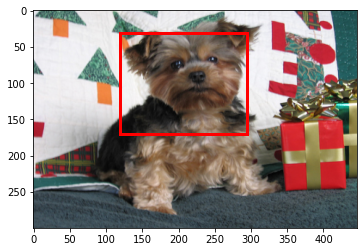

In [43]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])